# This is a model that predicts names of indian males using recurrent neural networks.

Trained on google colaboratory GPU hardware for over 14000 names.

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [3]:
# uploading dataset into google colab
# the dataset is taken from kaggle
from google.colab import files
uploaded = files.upload()
import io
male_names = pd.read_csv(io.BytesIO(uploaded['Indian-Male-Names.csv']))

Saving Indian-Male-Names.csv to Indian-Male-Names.csv


In [4]:
#take a look at data
male_names.head()

,name,gender,race
0,barjraj,m,indian
1,ramdin verma,m,indian
2,sharat chandran,m,indian
3,birender mandal,m,indian
4,amit,m,indian


In [5]:
# we only need names
# so extracting names
full_name = male_names.name

# dropping nan
full_name.dropna(inplace=True)
full_name.shape


(14821,)

In [0]:
#some preprocessing 
def is_good(n):
    alphabets = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    for i in n:
        if i not in alphabets:
            return False
        
    return True
cleaned_names = []
max_len_name = -1
for name in list(full_name):
    # replacing "@" with ' '
    new_name = name.replace('@',' ')
    # extracting first name
    new_name = new_name.split(' ')[0]
    if is_good(new_name):
        if len(new_name)>max_len_name:
            max_len_name = len(new_name)
        cleaned_names.append(list(new_name))
#cleaned_names[0]
#print(len(cleaned_names))
#['b', 'a', 'r', 'j', 'r', 'a', 'j']

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizing and generating the input sequences
# notice that padding is used here
tokenizer = Tokenizer(oov_token = "<OOV>")
tokenizer.fit_on_texts(cleaned_names)
print(tokenizer.word_index)
total_chars = len(tokenizer.word_index) + 1
input_sequences = []
for name in cleaned_names:
    token_list = tokenizer.texts_to_sequences([name])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
max_sequence_len = max([len(x) for x in input_sequences])
input_sequence = np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))



{'<OOV>': 1, 'a': 2, 'r': 3, 'h': 4, 'n': 5, 's': 6, 'i': 7, 'e': 8, 'm': 9, 'd': 10, 'u': 11, 'k': 12, 'j': 13, 'l': 14, 't': 15, 'o': 16, 'v': 17, 'p': 18, 'b': 19, 'y': 20, 'g': 21, 'c': 22, 'w': 23, 'f': 24, 'z': 25, 'x': 26, 'q': 27}


In [8]:
# take a look at the generated sequences
input_sequence[:3]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 19,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        19,  2,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 19,
         2,  3, 13]], dtype=int32)

In [0]:
#splitting training and test data
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
xs = input_sequence[:,:-1]
labels = input_sequence[:,-1]
ys = to_categorical(labels,num_classes = total_chars)
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

In [45]:
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

num_dimensions = 64

#initializing model
model = Sequential()

#adding embedding layer
model.add(Embedding(total_chars, num_dimensions, input_length = max_sequence_len-1))

#adding lstm layer
model.add(Bidirectional(LSTM(32)))

#adding dnn
model.add(Dense(26,activation='relu'))
model.add(Dense(total_chars,activation='softmax'))

#compiling and training
adam=Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
          

Train on 46950 samples, validate on 23125 samples
Epoch 1/5
46950/46950 [==============================] - 220s 5ms/sample - loss: 1.8866 - acc: 0.4269 - val_loss: 1.6977 - val_acc: 0.4707
Epoch 2/5
46950/46950 [==============================] - 217s 5ms/sample - loss: 1.6484 - acc: 0.4964 - val_loss: 1.6147 - val_acc: 0.5120
Epoch 3/5
46950/46950 [==============================] - 218s 5ms/sample - loss: 1.5780 - acc: 0.5202 - val_loss: 1.5858 - val_acc: 0.5218
Epoch 4/5
46950/46950 [==============================] - 217s 5ms/sample - loss: 1.5488 - acc: 0.5250 - val_loss: 1.5643 - val_acc: 0.5159
Epoch 5/5
46950/46950 [==============================] - 218s 5ms/sample - loss: 1.5158 - acc: 0.5370 - val_loss: 1.5505 - val_acc: 0.5418


It has low accuracy as you can see but can be improved by adjusting layers and hyperparameter tuning.

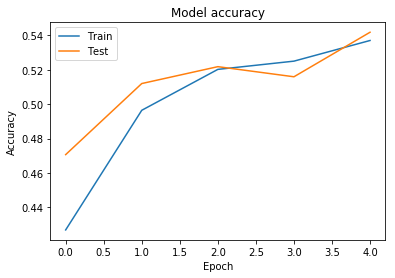

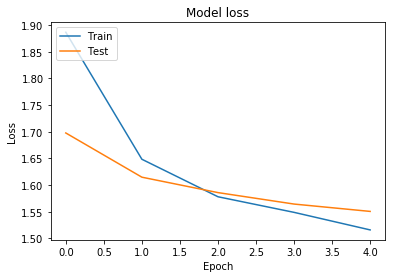

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [49]:
# predicting the new names
pre = 'b'

# how much further characters do you want 
next_chars = 6
for _ in range(next_chars):
    token_list = tokenizer.texts_to_sequences([pre])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1,padding='pre')
    predicted = model.predict_classes(token_list,verbose=0)
    for char,index in tokenizer.word_index.items():
        if index==predicted:
            output_char = char
            break
    pre += output_char
print(pre)

baaaaaa
